[View in Colaboratory](https://colab.research.google.com/github/gshashank84/learn-pytorch/blob/master/Image_Classifier.ipynb)

# Image Classifier

### Dataset -> CIFAR10

- Import Dataset
- Design model
- Specify Hyperparameters
- Forward Prop
- Compute Loss
- Backward Prop
- Update Gradients

In [1]:
!pip install torch
!pip install torchvision
!pip install livelossplot

    100% |████████████████████████████████| 519.5MB 31kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5a49a000 @  0x7f03d64671c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 5.4MB/s 
    100% |████████████████████████████████| 2.0MB 9.5MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Running setup.py bdist_wheel for livelossplot ... - \ done
  Stored in directory: /root/.cache/pip/wheels/67/8b/e9/3990164e3b2a421145b9d9d76fc8aa889225d495b043faeb73
Successfully built livelossplot


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
import torchvision.transforms as transforms
from livelossplot import PlotLosses
import matplotlib.pyplot
% matplotlib inline

Using TensorFlow backend.


In [3]:
torch.cuda.is_available()

True

#### Model

In [0]:
class Net(nn.Module):
    def __init__(self,input_channel,hidden_channel,out_channel, input_size, hidden_size, num_classes):
        super(Net, self).__init__()
        self.conv2d = nn.Conv2d(input_channel,hidden_channel,
                                kernel_size=3,
                                stride=1,padding=1)
        self.conv2d_p = nn.Conv2d(hidden_channel, out_channel,
                                 kernel_size= 5, stride=1)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.relu = nn.ReLU()
        self.BatchNorm2d = nn.BatchNorm2d(hidden_channel)  # n_Channel
        self.BatchNorm2d_p = nn.BatchNorm2d(out_channel)
        self.sigmoid = nn.Sigmoid()
        self.MaxPool2d = nn.MaxPool2d(kernel_size=3,stride=1)
        self.Dropout2d = nn.Dropout2d(p=0.5)
        
    def forward(self, x):
        x = self.conv2d(x)
        x = self.BatchNorm2d(x)
        x = self.MaxPool2d(x)
        x = self.relu(x)
        x = self.conv2d_p(x)
        x = self.BatchNorm2d_p(x)
        x = F.relu(F.max_pool2d(x,3))
        x = x.reshape(x.size(0),-1) 
        x = self.fc1(x)
        x = self.sigmoid(x)
        x = self.Dropout2d(x)
        x = self.fc2(x)
        return x
        

### Dataset load

In [5]:
train_data = torchvision.datasets.CIFAR10(root = './data',
                                              train = True,
                                              transform = transforms.ToTensor(),
                                              download = True)

test_data = torchvision.datasets.CIFAR10(root = './data',
                                             train = False,
                                             transform = transforms.ToTensor(),
                                             download = True)

train_loader = torch.utils.data.DataLoader(dataset= train_data,
                                          batch_size= 100,
                                          shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset= test_data,
                                         batch_size = 100,
                                         shuffle = False)

Files already downloaded and verified


Implementation

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [0]:
input_channel = 3
hidden_channel = 15
out_channel = 25
num_classes = 10
input_size = out_channel*8*8
hidden_size = 500
epochs = 25
total_step = len(train_loader)
val_total_step = len(test_loader)

In [0]:
model = Net(input_channel,hidden_channel,out_channel, input_size, hidden_size, num_classes).to(device)

In [0]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [0]:
liveloss = PlotLosses()

In [11]:
for epoch in range(epochs):
    avg_accuracy = 0
    avg_loss = 0
    total = 0
    val_total = 0
    val_avg_loss = 0
    val_avg_accuracy = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.reshape(-1,input_channel,32,32).to(device)
        labels = labels.to(device)
        
        #Forward Prop
        output = model(images)
        loss = criterion(output, labels)
        
        _,predicted = torch.max(output.data, 1)

        total += labels.size(0)
        avg_loss += loss.item()
        avg_accuracy += (labels == predicted).sum().item()
        
        #Backward Prop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1)%(total_step) == 0:
            print('Epoch: {}/{}, step: {}/{}, loss: {:.4f}'.format(epoch+1,
                                                              epochs,
                                                              i+1,
                                                              total_step,
                                                              loss.item()))
        
      
        
        
  # The below code is for only validation loss and accuracy 
    
    for val_images, val_labels in test_loader:
      val_images = val_images.reshape(-1, input_channel,32,32).to(device)
      val_labels = val_labels.to(device)
      
      val_output = model(val_images)
      val_loss = criterion(val_output, val_labels)
      _, val_predicted = torch.max(val_output.data, 1)
      
      val_total += val_labels.size(0)
      val_avg_loss += val_loss.item()
      val_avg_accuracy += (val_labels == val_predicted).sum().item()
    
    avg_loss = avg_loss/total_step
    avg_accuracy = avg_accuracy/total
    val_avg_loss = val_avg_loss/ val_total_step
    val_avg_accuracy = val_avg_accuracy/ val_total
    liveloss.update({'log loss': avg_loss,'val_log loss':val_avg_loss,
                     'accuracy': avg_accuracy,'val_accuracy':val_avg_accuracy})

Epoch: 1/25, step: 500/500, loss: 1.4079
Epoch: 2/25, step: 500/500, loss: 1.0167
Epoch: 3/25, step: 500/500, loss: 1.1113
Epoch: 4/25, step: 500/500, loss: 0.8793
Epoch: 5/25, step: 500/500, loss: 0.7177
Epoch: 6/25, step: 500/500, loss: 0.6775
Epoch: 7/25, step: 500/500, loss: 0.7675
Epoch: 8/25, step: 500/500, loss: 0.6890
Epoch: 9/25, step: 500/500, loss: 0.5361
Epoch: 10/25, step: 500/500, loss: 0.4384
Epoch: 11/25, step: 500/500, loss: 0.7000
Epoch: 12/25, step: 500/500, loss: 0.6408
Epoch: 13/25, step: 500/500, loss: 0.5202
Epoch: 14/25, step: 500/500, loss: 0.5485
Epoch: 15/25, step: 500/500, loss: 0.4312
Epoch: 16/25, step: 500/500, loss: 0.4233
Epoch: 17/25, step: 500/500, loss: 0.4532
Epoch: 18/25, step: 500/500, loss: 0.5158
Epoch: 19/25, step: 500/500, loss: 0.4155
Epoch: 20/25, step: 500/500, loss: 0.3234
Epoch: 21/25, step: 500/500, loss: 0.3494
Epoch: 22/25, step: 500/500, loss: 0.5302
Epoch: 23/25, step: 500/500, loss: 0.3109
Epoch: 24/25, step: 500/500, loss: 0.2486
E

In [12]:
#Evaluating the model
with torch.no_grad():    
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1,input_channel,32,32).to(device)
        labels = labels.to(device)

        output = model(images)
        _,predicted = torch.max(output.data, 1)

        total += labels.size(0)
        correct += (labels == predicted).sum().item()

    print('Accuracy: {}%'.format(100*correct/total))

Accuracy: 72.43%


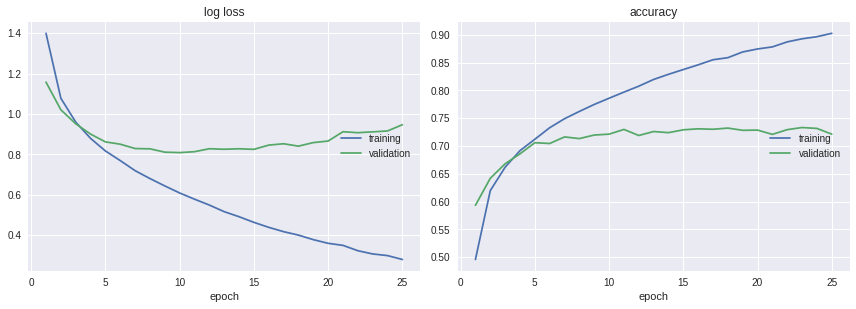

In [13]:
liveloss.draw()

In [0]:
#72% <-- Highest Accuracy so far